In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f752376c07ba0d0bf14c54cdeca743363a206fd399e4996655a0602573df2229
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
!wget https://raw.githubusercontent.com/hundredblocks/ml-powered-applications/master/ml_editor/model_evaluation.py
from model_evaluation import get_metrics, get_confusion_matrix_plot, get_roc_plot,\
get_calibration_plot, get_feature_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from lime.lime_tabular import LimeTabularExplainer
import joblib
%run '/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/gral_functions/gral_funcs_box_data.ipynb'
%run '/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/1_new_models_since_raw_data/funcs_model_2_short.ipynb'
%run '/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/gral_functions/pipeline_cleaner_raw_data.ipynb'
%run '/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/1_new_models_since_raw_data/clases_predictors.ipynb'
%xmode #verbose
import warnings
warnings.filterwarnings('ignore')

--2023-11-12 22:26:54--  https://raw.githubusercontent.com/hundredblocks/ml-powered-applications/master/ml_editor/model_evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8593 (8.4K) [text/plain]
Saving to: ‘model_evaluation.py.6’

model_evaluation.py 100%[===================>]   8.39K  --.-KB/s    in 0s      

2023-11-12 22:26:54 (69.8 MB/s) - ‘model_evaluation.py.6’ saved [8593/8593]



#### 0. preproces data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/__data__/raw_data_wiki_bets_no_procesed_23-9-30.csv')
# Cleaning of the trainer data
data2 = cleaner_raw_data(data)

In [ ]:
### exploration
temp = pd.Series([i for i in data2.boxstyle_b1.values] + [i for i in data2.boxstyle_b2])
temp = temp.str.replace('fighter','').str.replace('boxer','').str.replace('and','')\
.str.replace('counter puncher','counter').str.replace('peek a boo','peekaboo')\
.str.replace('muncher','puncher').str.replace('punching','puncher')\
.str.replace('counterpuncher','counter').str.replace('–','').str.strip()

temp2 = pd.DataFrame(temp.value_counts(), columns=['cant']).query('cant < 100 and cant > 50')
[[i,e] for i,e in zip(temp2.index, temp2.cant)]

[['scrappy pressure', 94],
 ['scrappy  aggressive pressure', 53],
 ['power puncher', 52]]

In [ ]:
# new data read
bo = pd.read_csv('/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/__data__/boxers_info_.csv')
fi = pd.read_csv('/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/__data__/fight_info_real.csv')
fr = pd.read_csv('/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/__data__/fight_results_real.csv')
# merge and split new data
ndf, new_id_df, new_other_cols = box_data_merger_spliter(bo,fi,fr)

#### 1. split data

In [ ]:
# separate the columns
res, pelea, X, y = data_column_sep(data2) # trainer data
res_new, pelea_new, X_new, y_new = data_column_sep(ndf) # real data

In [ ]:
# train data
xtrain,xval,ytrain,yval = train_test_split(X, y, test_size=.35,
                                           random_state=40, stratify=y)
# val test data
xval,xtest,yval,ytest = train_test_split(xval, yval, test_size=.15,
                                           random_state=40, stratify=yval)
# xl data
xl_train,xl_test,yl_train,yl_test = train_test_split(X, y, test_size=.30,
                                           random_state=40, stratify=y)

#### 2. check clusters

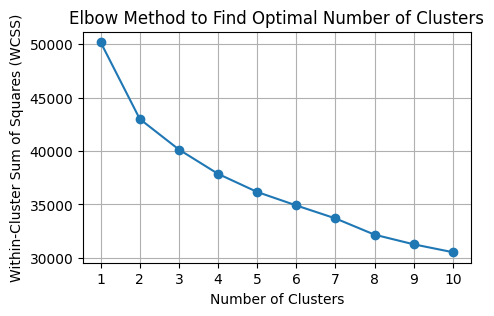

In [ ]:
find_optimal_clusters(xl_train)

In [ ]:
# train the cluster
cluster = Data_clusterer(KMeans(n_clusters=4, random_state=10))
xl_check = cluster.fit_transform(xl_train)

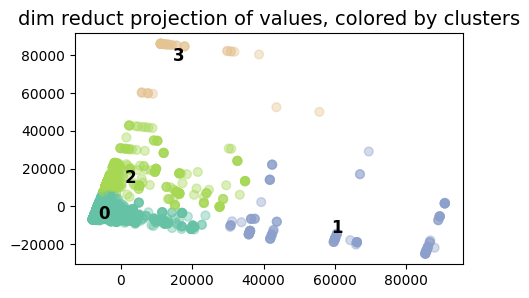

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(xl_train)
plot_clusters(xl_check.cluster, X_pca)

In [ ]:
xl_check.cluster.value_counts()

0    2170
2     440
1     136
3      43
Name: cluster, dtype: int64

#### 3. check cross val

In [ ]:
# cross val preprocesing steps
cluster = Data_clusterer(KMeans(n_clusters=4, random_state=10))
x_clus, x_fe, x_scal, _ = train_func_cross_val(xl_train, cluster)

Fit time mean: 0.705293607711792
Score time mean: 0.024302911758422852
Test score: [0.9390681  0.95698925 0.9390681  0.95340502 0.96588869]
Test mean score: 0.9508838310714722


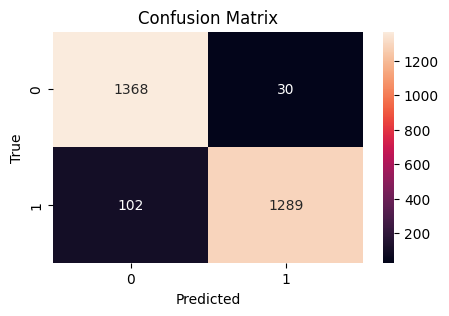

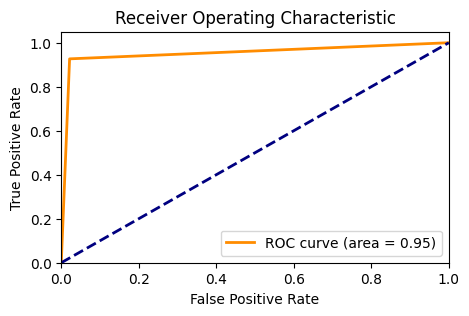

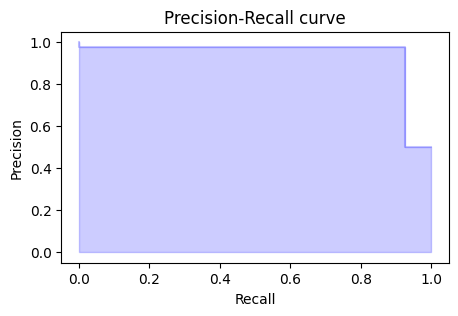

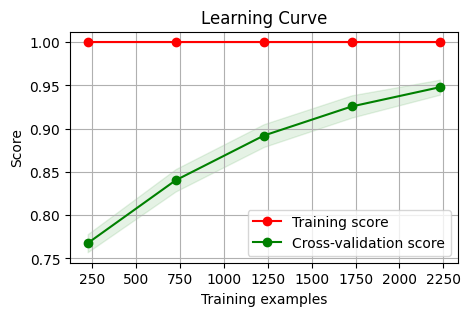

In [ ]:
cross_val(RandomForestClassifier(), x_scal, yl_train, cv=5)

Fit time mean: 0.42105779647827146
Score time mean: 0.09024491310119628
Test score: [0.85125448 0.83870968 0.83512545 0.84767025 0.83662478]
Test mean score: 0.8418769264428615


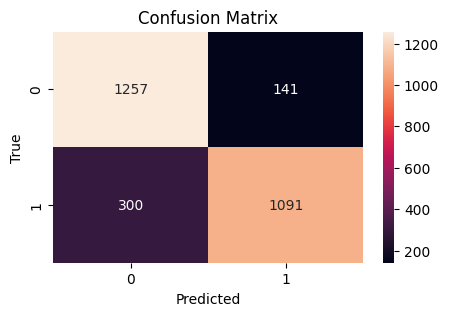

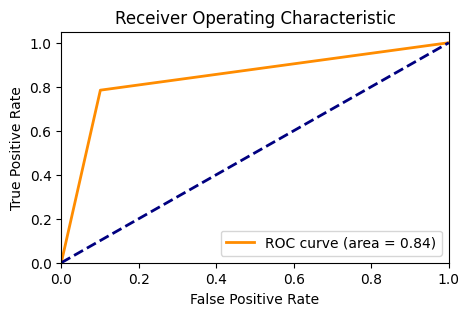

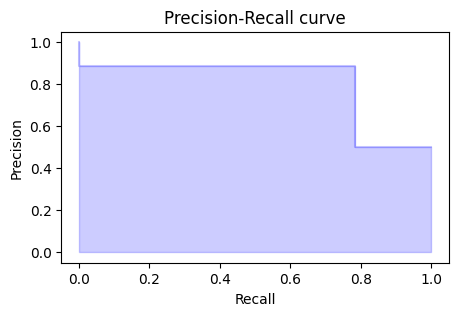

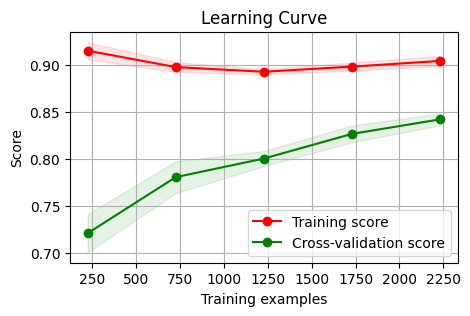

In [ ]:
cross_val(SVC(), x_scal, yl_train, cv=5)

Fit time mean: 0.3035080909729004
Score time mean: 0.0033598423004150392
Test score: [0.71684588 0.76344086 0.7311828  0.72222222 0.7037702 ]
Test mean score: 0.7274923907517874


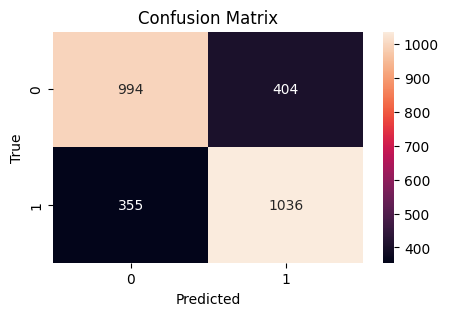

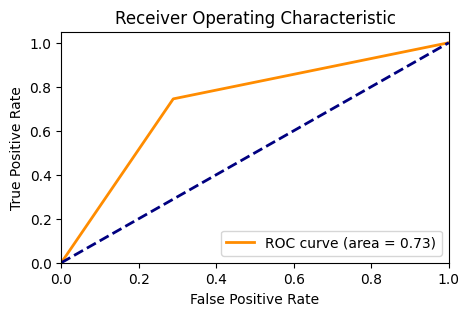

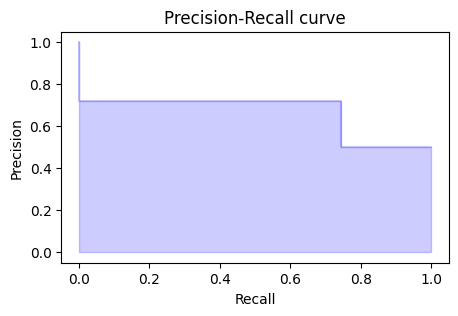

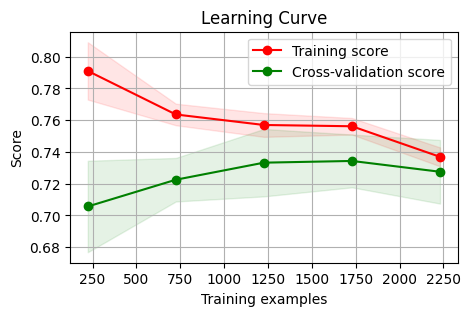

In [ ]:
cross_val(LinearSVC(), x_scal, yl_train, cv=5)

#### 4. val and test metrics

Linear SVC

In [ ]:
cluster = Data_clusterer(KMeans(n_clusters=4, random_state=10))
scaler = StandardScaler()
model = Model_applied(LinearSVC())
# trainer models fits on training data
x_clus, x_fe, x_scal, [cluster, scaler, model] = model_trainer(xtrain, ytrain, cluster, model, scaler)
xval_clus, xval_fe, xval_scal, yval_pred = new_preds(xval, cluster, scaler, model)

In [ ]:
get_metrics(yval_pred.boxer1_pred, yval)

(0.7333333333333333,
 0.7333849931911548,
 0.7333333333333333,
 0.7333257370744908)

In [ ]:
# Get the coefficients (weights) assigned to each feature
coefficients = model.model.coef_

# Calculate the absolute values of the coefficients to gauge importance
feature_importance = np.abs(coefficients)

pd.DataFrame(data=feature_importance,
             columns=x_fe.columns).T\
             .sort_values(0, ascending=False).\
             rename(columns={0:'feat_importance'})

,feat_importance
len_text_boxer2,0.298501
birth_b1,0.262942
b1_more_fame,0.220762
b1_wk,0.183123
birth_b2,0.158474
len_text_boxer1,0.153751
b2_w,0.137364
b1_lk,0.113526
b1_mas_ko_perc,0.110548
b2_invicto,0.105826


In [ ]:
# no pred proba so get the decission values instead
decision_values = model.model.decision_function(xval_scal)
yval_pred['dec_val'] = decision_values
# compute the values acording to already made funcs for pred proba
mmscaler = MinMaxScaler()
temp = convert_dec_val_to_probs(yval_pred, mmscaler)
yval_pred = pd.concat([yval_pred, temp], axis=1)

Min val scaled (negative): [0.00026546], max val scaled (negative): [2.82706051]
Min val scaled (positive): [0.00141049], max val scaled (positive): [1.95737348]


	Brier: 0.192


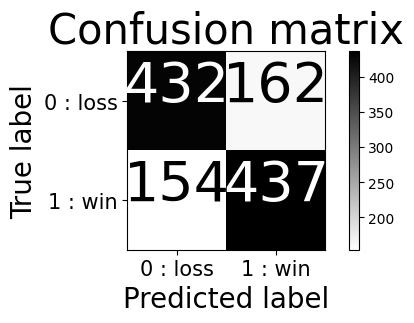

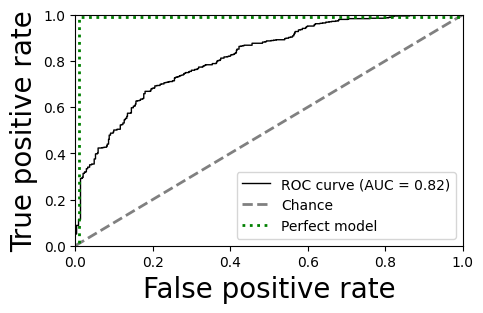

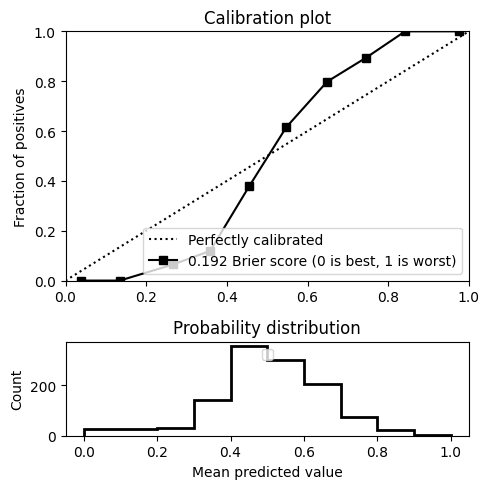

In [ ]:
get_confusion_matrix_plot(yval_pred.boxer1_pred, yval,
                          figsize=(5, 3), classes=['0 : loss','1 : win'])
get_roc_plot(yval_pred.prob_win, yval, figsize=(5,3))
get_calibration_plot(yval_pred.prob_win, yval, figsize=(5, 5))

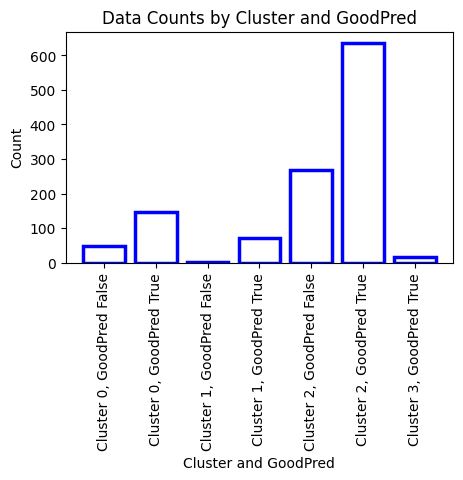

Porcentaje de False per Trues by clusters
cluster
0    0.321918
1    0.028571
2    0.419152
3    0.000000
dtype: float64


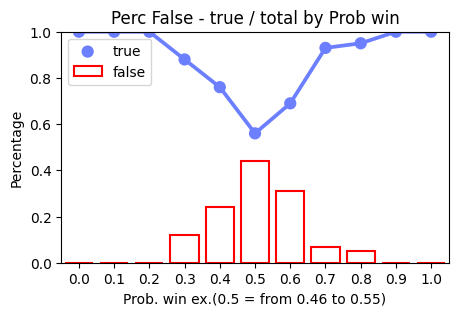

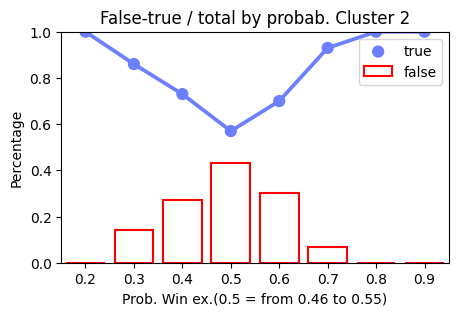

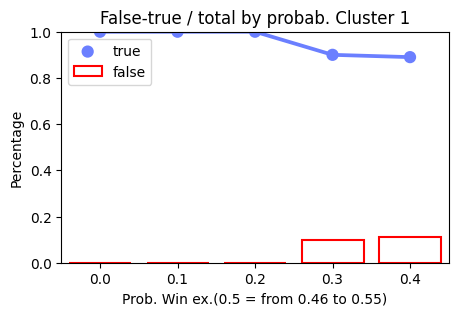

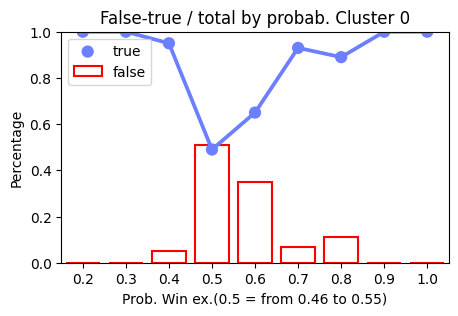


::: Attribute error in cluster: 3 :::



In [ ]:
dfx = check_fails_and_probas(xval_clus, yval, yval_pred.boxer1_pred, yval_pred.prob_loss, yval_pred.prob_win)

SVC

In [ ]:
cluster = Data_clusterer(KMeans(n_clusters=4, random_state=10))
scaler = StandardScaler()
model = Model_applied(SVC(probability=True))
# trainer models fits on training data
x_clus, x_fe, x_scal, [cluster, scaler, model] = model_trainer(xtrain, ytrain, cluster, model, scaler)
xval_clus, xval_fe, xval_scal, yval_pred = new_preds(xval, cluster, scaler, model)

In [ ]:
get_metrics(yval_pred.boxer1_pred, yval)

(0.8676222596964587,
 0.8705440863263385,
 0.8676222596964587,
 0.8673372887281544)

In [ ]:
# use the permutation impotance to get feature importance
permutation_results = permutation_importance(model.model, xval_scal, yval, n_repeats=30)
feature_importance = permutation_results.importances_mean

In [ ]:
pd.DataFrame(data=[feature_importance],
             columns=xval_fe.columns).T\
             .sort_values(0, ascending=False).\
             rename(columns={0:'feat_importance'})

,feat_importance
birth_b1,0.049270
b1_more_fame,0.044585
birth_b2,0.040432
b1_wk,0.031397
len_text_boxer2,0.030415
height_b2,0.026375
b1_lk,0.023765
b1_momios_menores,0.018855
b1_mas_loss_perc,0.015881
b2_w,0.015685


	Brier: 0.098


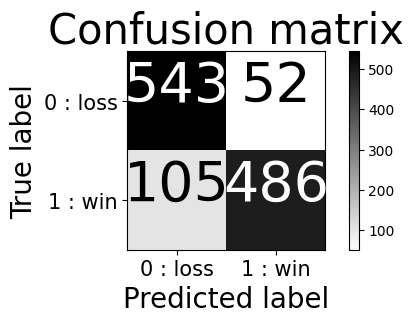

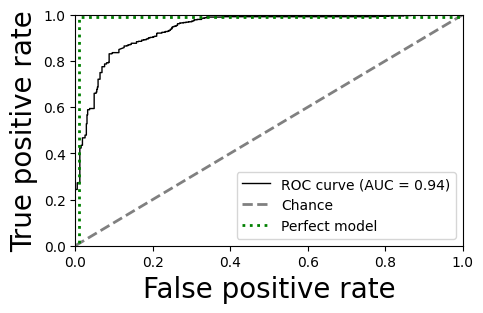

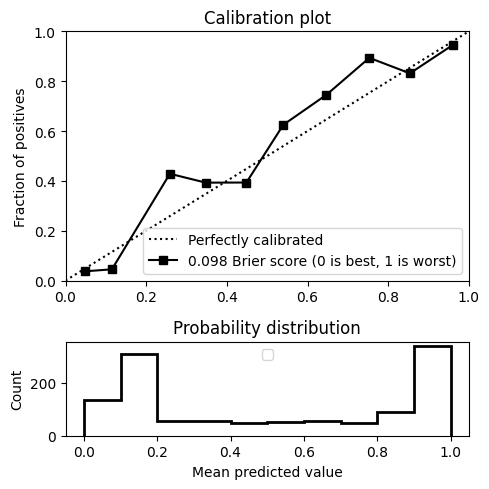

In [ ]:
get_confusion_matrix_plot(yval_pred.boxer1_pred, yval,
                          figsize=(5, 3), classes=['0 : loss','1 : win'])
get_roc_plot(yval_pred.prob_win, yval, figsize=(5,3))
get_calibration_plot(yval_pred.prob_win, yval, figsize=(5, 5))

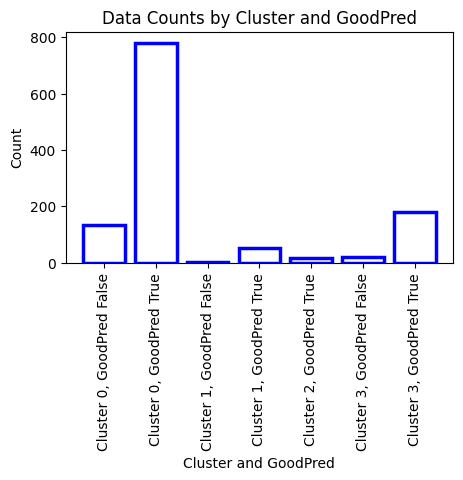

Porcentaje de False per Trues by clusters
cluster
0    0.171575
1    0.038462
2    0.000000
3    0.117978
dtype: float64


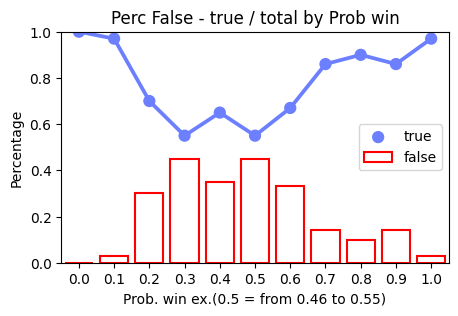

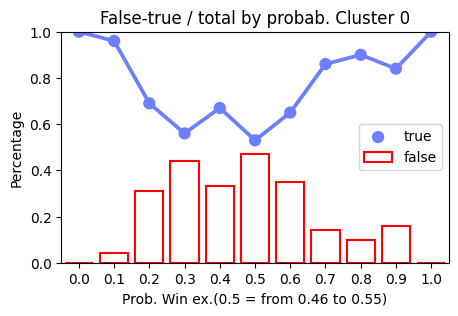

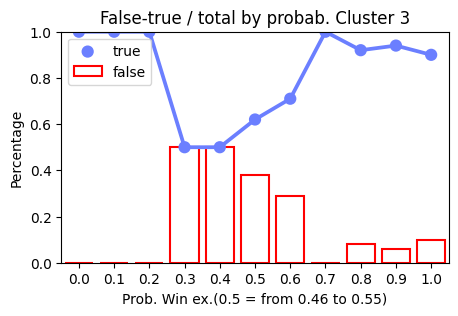

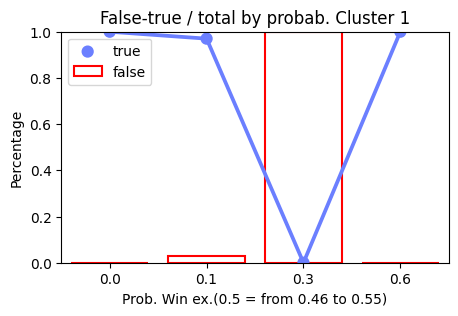


::: Attribute error in cluster: 2 :::



In [ ]:
dfx = check_fails_and_probas(xval_clus, yval, yval_pred.boxer1_pred, yval_pred.prob_loss, yval_pred.prob_win)

#### 5. hyperparams

In [ ]:
x_0 = feat_eng_2(xtrain)
cluster = KMeans(n_clusters=5, random_state=10)
x_clus = cluster.fit_transform(x_0)
scaler = StandardScaler()
x_scal = scaler.fit_transform(x_clus)

In [ ]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': np.arange(10, 200, 10),  # Number of trees in the forest
    'max_depth': np.arange(1, 20),          # Maximum depth of each tree
    'min_samples_split': np.arange(2, 11),  # Minimum samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11),   # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider for the best split
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_classifier,          # The model to tune
    param_distributions=param_grid,  # The parameter grid to search over
    n_iter=50,               # Number of parameter settings to sample
    cv=5,                    # Cross-validation folds
    n_jobs=-1                # Use all available CPU cores
)

# Perform the random search
random_search.fit(x_scal, ytrain)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Accuracy: {:.2f}%".format(random_search.best_score_ * 100))

Best Hyperparameters:  {'n_estimators': 140, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 4}
Best Accuracy: 83.24%


Fit time mean: 0.8254220485687256
Score time mean: 0.028531646728515624
Test score: [0.85512821 0.82564103 0.82820513 0.84230769 0.84487179]
Test mean score: 0.8392307692307692


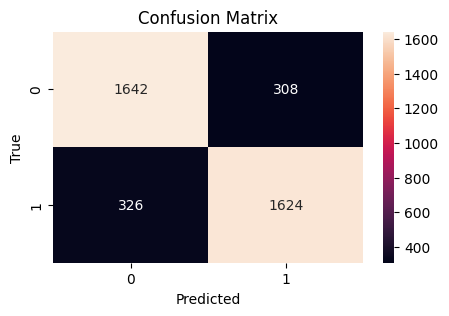

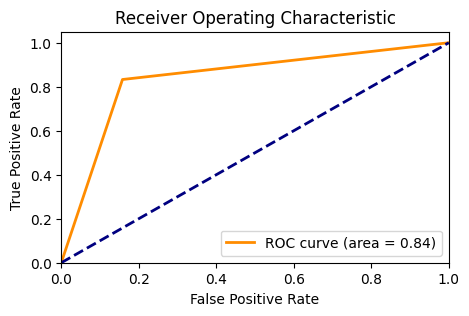

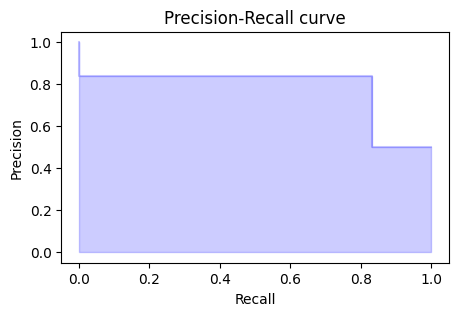

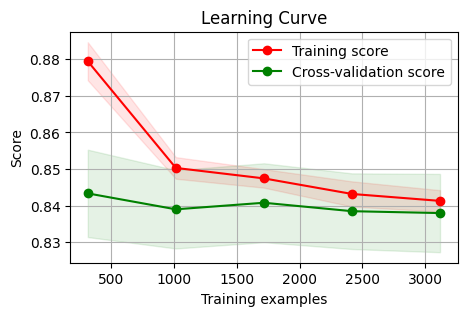

In [ ]:
cross_val(RandomForestClassifier(n_estimators=190,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 max_features='sqrt',
                                 max_depth=4),
          xtrain_2, yl_train.replace({'loss':-1,'win':1}), cv=5)

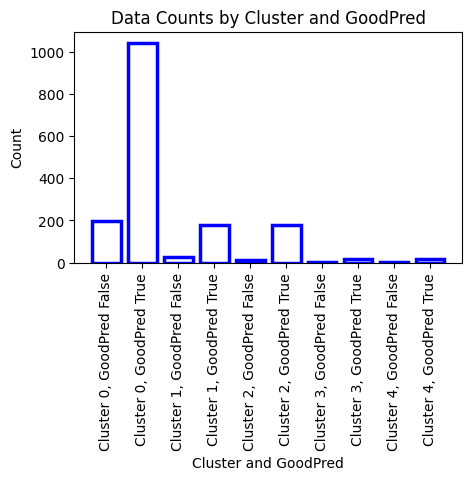

Porcentaje de False per Trues by clusters
cluster
0    0.187919
1    0.156425
2    0.073864
3    0.055556
4    0.058824
dtype: float64


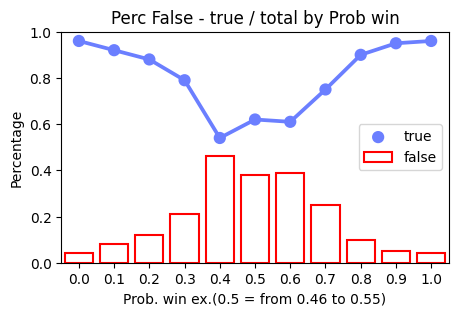

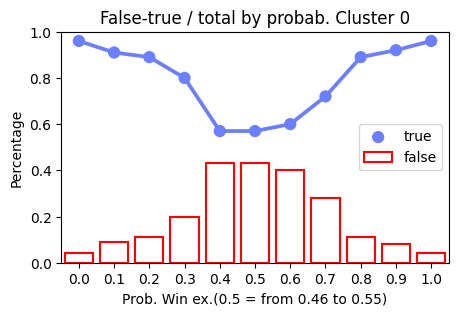

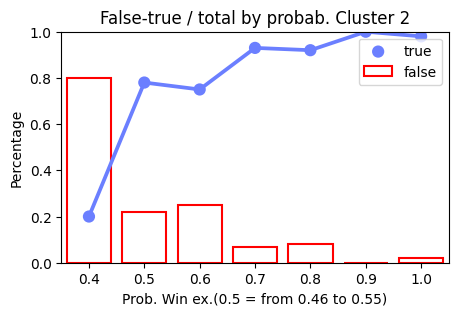

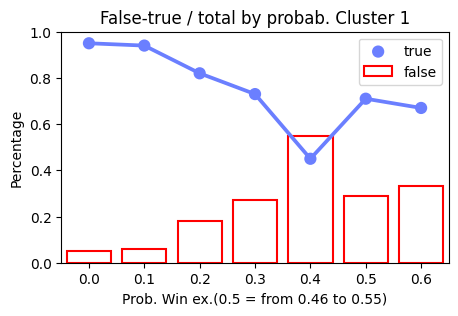

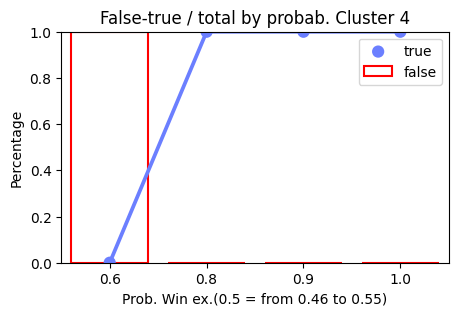

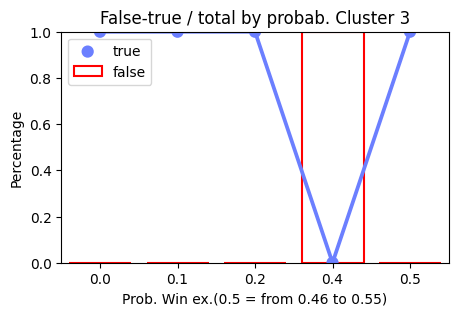

In [ ]:
## no hyper
# entrenar
cluster, scaler, model, xtrain_cluster, model_obj = model_trainer(xl_train, yl_train, feat_eng_2,
              KMeans(n_clusters=5, random_state=10),
              StandardScaler(), RandomForestClassifier())

# predecir
xl_0 = feat_eng_2(xl_test)
xl_clus = cluster.transform(xl_0)
xl_scal = scaler.transform(xl_clus)
yl_pred = model_obj.transform(xl_scal)

# check
temp = check_fails_and_probas(xl_clus, yl_test, yl_pred.boxer1_pred, yl_pred.prob_loss, yl_pred.prob_win)

In [ ]:
get_metrics(yl_pred.boxer1_pred, yl_test)

(0.8570574162679426,
 0.8572828600267735,
 0.8570574162679426,
 0.8570348636903371)

Top 10 importances:

b1_more_fame: 0.2
len_text_boxer1: 0.16
len_text_boxer2: 0.14
b2_bet_inversa: 0.046
b1_wk: 0.046
b1_bet_inversa: 0.045
b2_wk: 0.043
b2_w: 0.041
b1_w: 0.04
b1_l: 0.026

Bottom 10 importances:

cluster: 0.016
b1_mas_win_perc: 0.012
b1_menos_ko_perc: 0.011
b1_mas_ko_perc: 0.01
b1_menos_peleas: 0.0064
b1_mas_peleas: 0.0056
b1_mas_loss_perc: 0.0051
b1_menos_loss_perc: 0.0047
b1_invicto: 0.0031
b2_invicto: 0.003


	Brier: 0.109


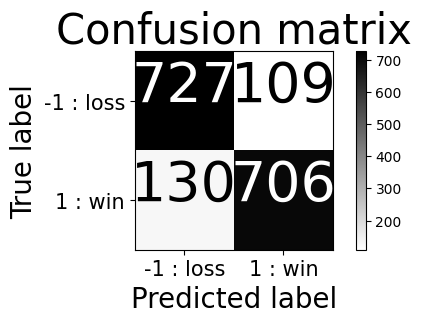

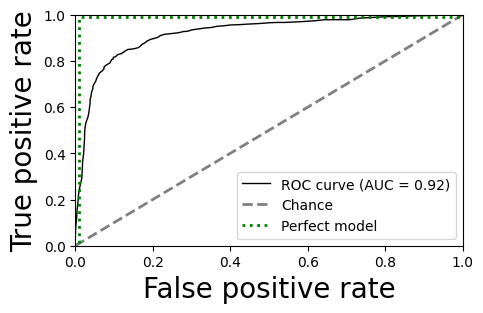

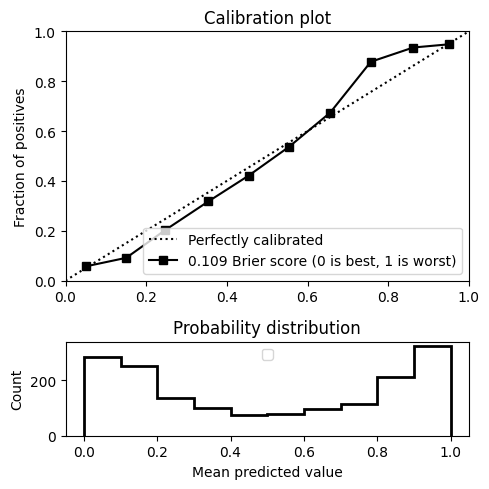

In [ ]:
feature_names = xl_clus.columns
k = 10
print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model, feature_names)[:k]]))
print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model, feature_names)[-k:]]))
get_confusion_matrix_plot(yl_pred.boxer1_pred, yl_test,
                          figsize=(5, 3), classes=['-1 : loss','1 : win'])
get_roc_plot(yl_pred.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5,3))
get_calibration_plot(yl_pred.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5, 5))

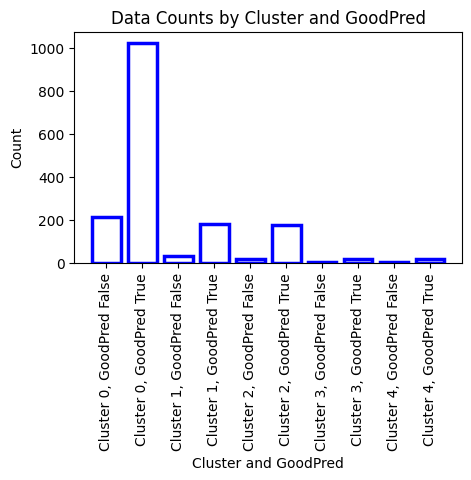

Porcentaje de False per Trues by clusters
cluster
0    0.208780
1    0.162921
2    0.086207
3    0.055556
4    0.058824
dtype: float64


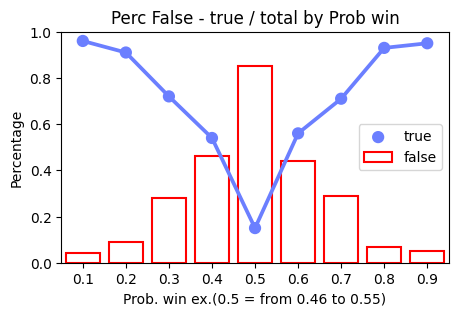

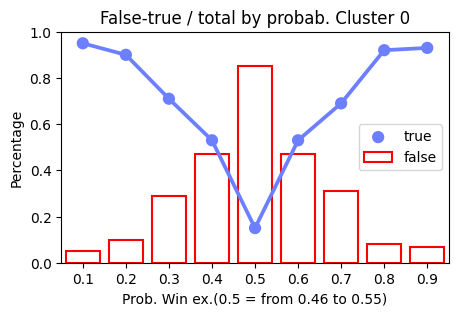

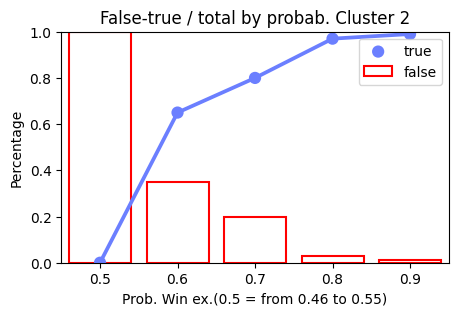

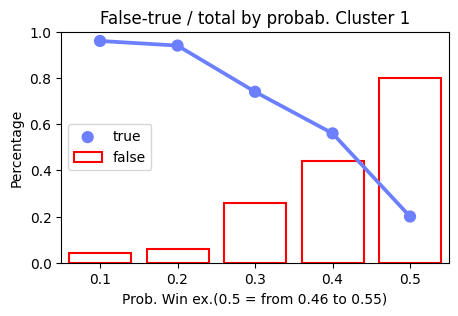

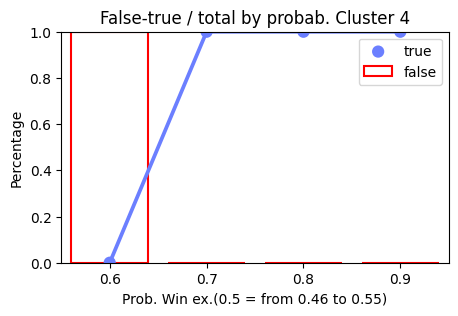

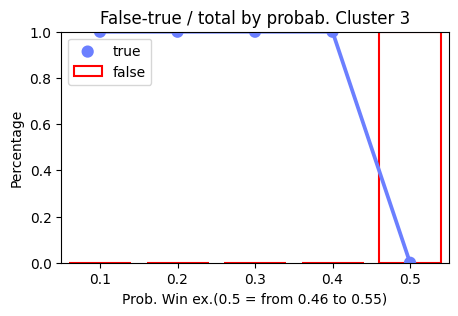

In [ ]:
## hyper
# entrenar
cluster_hype, scaler_hype, model_hype, xtrain_cluster_hype, model_obj_hype = model_trainer(xl_train, yl_train, feat_eng_2,
              KMeans(n_clusters=5, random_state=10),
              StandardScaler(), RandomForestClassifier(n_estimators=190,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 max_features='sqrt',
                                 max_depth=4))

# predecir
xl_0 = feat_eng_2(xl_test)
xl_clus = cluster_hype.transform(xl_0)
xl_scal = scaler_hype.transform(xl_clus)
yl_pred_hype = model_obj_hype.transform(xl_scal)

# check
temp = check_fails_and_probas(xl_clus, yl_test, yl_pred_hype.boxer1_pred, yl_pred_hype.prob_loss, yl_pred_hype.prob_win)

In [ ]:
get_metrics(yl_pred_hype.boxer1_pred, yl_test)

(0.8444976076555024,
 0.8450030951234611,
 0.8444976076555024,
 0.8444406275048666)

Top 10 importances:

b1_more_fame: 0.38
len_text_boxer1: 0.24
len_text_boxer2: 0.17
b1_momios_menores: 0.036
b1_mas_win_perc: 0.028
cluster: 0.023
b1_menos_win_perc: 0.021
b1_wk: 0.021
b2_wk: 0.016
b2_bet_inversa: 0.012

Bottom 10 importances:

b1_menos_peleas: 0.0021
b1_menos_loss_perc: 0.0018
b1_l: 0.0016
b1_mas_loss_perc: 0.0014
b1_lk: 0.0012
b2_invicto: 0.00081
b2_lk: 0.00081
b1_d: 0.00069
b2_d: 0.00046
b1_invicto: 7.6e-05


	Brier: 0.114


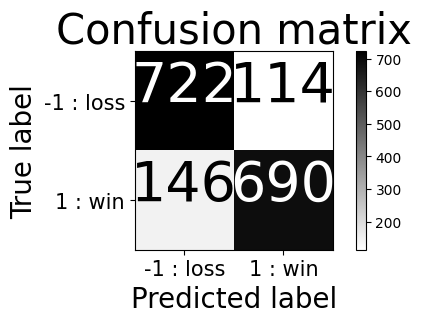

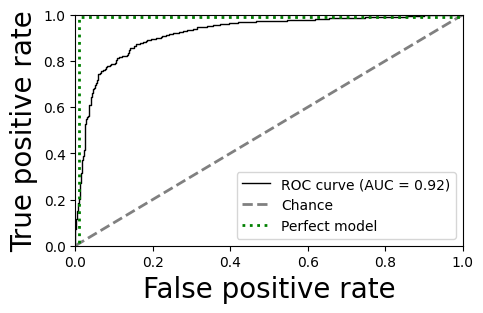

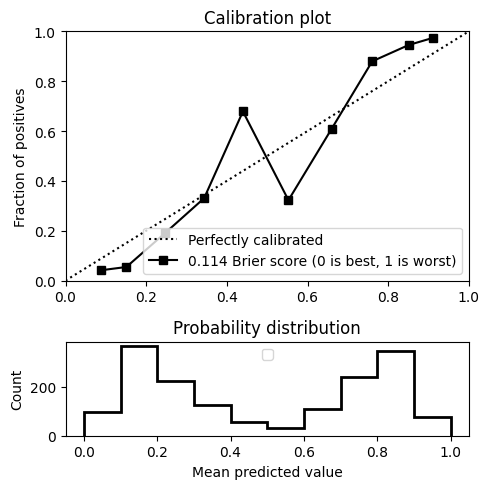

In [ ]:
feature_names = xl_clus.columns
k = 10
print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model_hype, feature_names)[:k]]))
print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model_hype, feature_names)[-k:]]))
get_confusion_matrix_plot(yl_pred_hype.boxer1_pred, yl_test,
                          figsize=(5, 3), classes=['-1 : loss','1 : win'])
get_roc_plot(yl_pred_hype.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5,3))
get_calibration_plot(yl_pred_hype.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5, 5))

#### 6. test new data

##### all data cross val checks

Fit time mean: 0.6502481460571289
Score time mean: 0.0022371292114257814
Test score: [0.73651192 0.72396487 0.71643664 0.74529486 0.73776662]
Test mean score: 0.7319949811794229


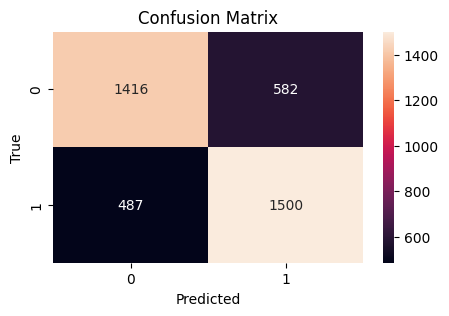

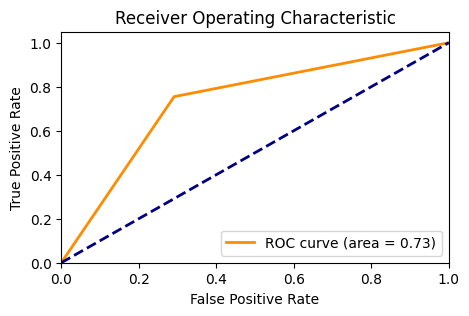

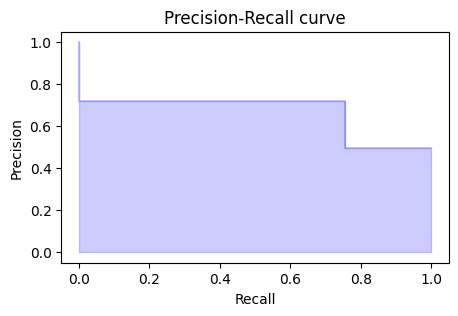

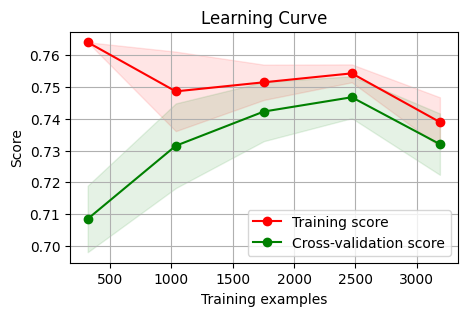

In [ ]:
cluster = Data_clusterer(KMeans(n_clusters=4, random_state=10))
x_clus, x_fe, x_scal, _ = train_func_cross_val(X, cluster)
cross_val(LinearSVC(), x_scal, y, cv=5)

Fit time mean: 2.8977682113647463
Score time mean: 0.15180282592773436
Test score: [0.86574655 0.86323714 0.85947302 0.87452949 0.87327478]
Test mean score: 0.8672521957340026


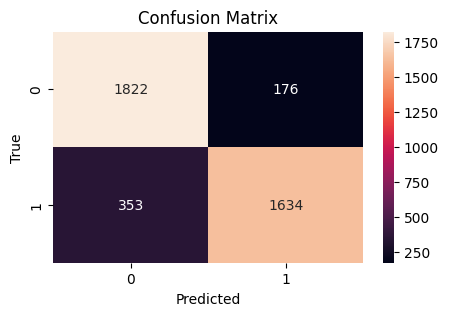

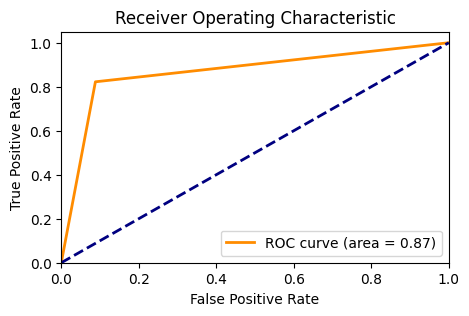

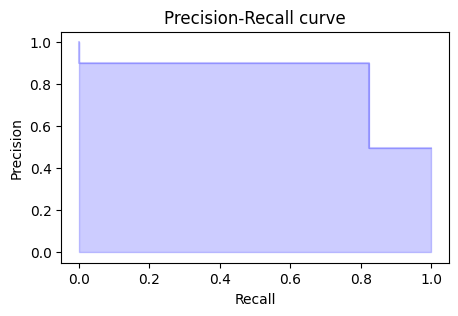

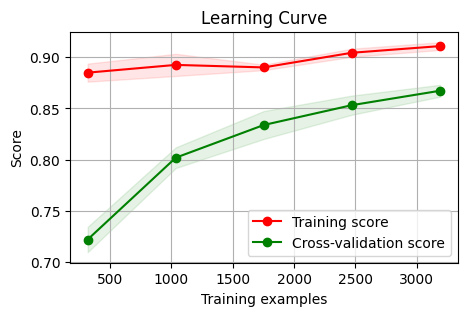

In [ ]:
cross_val(SVC(probability=True), x_scal, y, cv=5)

##### new predictions

SVC

In [ ]:
cluster = Data_clusterer(KMeans(n_clusters=4, random_state=10))
scaler = StandardScaler()
model = Model_applied(SVC(probability=True))
# trainer models fits on training data
x_clus, x_fe, x_scal, [cluster, scaler, model, explainer] = model_trainer(X, y, cluster, model, scaler)
xn_clus, xn_fe, xn_scal, yn_pred = new_preds(X_new, cluster, scaler, model)

In [ ]:
df1, df2, df3 = check_predictions(res_new, pelea_new, yn_pred, new_id_df, xn_clus)

In [ ]:
df1

,initial_index,goodpred,prob_win,cluster,boxer1_pred,result,b1_bet,b2_bet,boxer1,boxer2,endround,endtype
0,0,True,0.997165,2,1,1,1.030,1.27,canelo alvarez,john ryder,12.0,dec
1,1,True,0.885933,2,1,1,1.060,1.16,canelo alvarez,jermell charlo,12.0,des
2,2,True,0.983067,2,1,1,1.040,1.24,tyson fury,francis ngannou,12.0,des
3,3,True,0.991182,0,1,1,1.040,1.27,delante johnson,ricardo quiroz,8.0,dec
4,4,False,0.877331,0,1,0,1.100,1.10,kevin barron crespo,christian olivo barreda,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
66,72,,0.932757,0,1,NaN,1.167,5.50,michael conlan,jordan gill,NaN,NaN
67,73,,0.943830,0,1,NaN,1.250,4.00,ryan garcia,oscar duarte,NaN,NaN
68,74,,0.035641,0,0,NaN,3.500,1.30,regis prograis,devin haney,NaN,NaN
69,75,,0.121240,1,0,NaN,1.300,3.50,artur beterbiev,callum smith,NaN,NaN


In [ ]:
sdf1na = df1[df1.result.notna()]

In [ ]:
sdf1na.goodpred.value_counts()

True     44
False    14
Name: goodpred, dtype: int64

Linear svc

In [ ]:
cluster = Data_clusterer(KMeans(n_clusters=4, random_state=10))
scaler = StandardScaler()
model = Model_applied(LinearSVC())
# trainer models fits on training data
x_clus, x_fe, x_scal, [cluster, scaler, model] = model_trainer(X, y, cluster, model, scaler)
xn_clus, xn_fe, xn_scal, yn_pred = new_preds(X_new, cluster, scaler, model)
# no pred proba so get the decission values instead
decision_values = model.model.decision_function(xn_scal)
yn_pred['dec_val'] = decision_values
# compute the values acording to already made funcs for pred proba
mmscaler = MinMaxScaler()
yn_pred1 = convert_dec_val_to_probs(yn_pred, mmscaler)
df1, df2, df3 = check_predictions(res_new, pelea_new, yn_pred1, new_id_df, xn_clus)

Min val scaled (negative): [0.001695], max val scaled (negative): [1.35174255]
Min val scaled (positive): [0.01489591], max val scaled (positive): [1.57648095]


In [ ]:
lsdf1na = df1[df1.result.notna()]

In [ ]:
lsdf1na.goodpred.value_counts()

True     36
False    22
Name: goodpred, dtype: int64

Compraciones

In [ ]:
temp = pd.concat([sdf1na[['goodpred','prob_win','result','cluster','b1_bet','b2_bet']], lsdf1na[['goodpred','prob_win','result']]], axis=1)

In [ ]:
temp.columns = ['sgoodpred', 'sprob_win', 'sresult', 'cluster', 'b1_bet', 'b2_bet',
       'lgoodpred', 'lprob_win', 'lresult']

In [ ]:
print(f'cluster 0\n{temp[temp.cluster == 0].sgoodpred.value_counts()}')
print(f'cluster 0\n{temp[temp.cluster == 0].lgoodpred.value_counts()}')

cluster 0
True     34
False    12
Name: sgoodpred, dtype: int64
cluster 0
True     27
False    19
Name: lgoodpred, dtype: int64


In [ ]:
print(f'cluster 1\n{temp[temp.cluster == 1].sgoodpred.value_counts()}')
print(f'cluster 1\n{temp[temp.cluster == 1].lgoodpred.value_counts()}')

cluster 1
True    4
Name: sgoodpred, dtype: int64
cluster 1
True    4
Name: lgoodpred, dtype: int64


In [ ]:
print(f'cluster 2\n{temp[temp.cluster == 2].sgoodpred.value_counts()}')
print(f'cluster 2\n{temp[temp.cluster == 2].lgoodpred.value_counts()}')

cluster 2
False    1
Name: sgoodpred, dtype: int64
cluster 2
False    1
Name: lgoodpred, dtype: int64


In [ ]:
print(f'cluster 3\n{temp[temp.cluster == 3].sgoodpred.value_counts()}')
print(f'cluster 3\n{temp[temp.cluster == 3].lgoodpred.value_counts()}')

cluster 3
True     5
False    2
Name: sgoodpred, dtype: int64
cluster 3
True     5
False    2
Name: lgoodpred, dtype: int64


In [ ]:
temp[(temp.sgoodpred == False) | (temp.lgoodpred == False)]

,sgoodpred,sprob_win,sresult,cluster,b1_bet,b2_bet,lgoodpred,lprob_win,lresult
4,False,0.880195,0,0,1.100,1.10,False,0.615882,0
6,False,0.675334,0,0,1.050,1.20,True,0.390481,0
12,False,0.017870,1,0,1.080,1.08,False,0.460154,1
15,False,0.346968,1,0,1.050,1.19,True,0.519652,1
20,False,0.473586,1,0,1.060,1.18,True,0.567718,1
22,False,0.906482,0,0,1.050,1.20,False,0.637335,0
23,True,0.041505,0,0,1.060,1.16,False,0.550806,0
24,False,0.151206,1,0,1.060,1.19,False,0.484799,1
25,False,0.236141,1,0,1.070,1.15,False,0.440508,1
27,False,0.168345,1,0,1.050,1.25,False,0.426707,1


Conclusion

After evaluating the performance of the Random Forest model, I opted not to proceed further due to evident overfitting on the training data, attributed to unmodified hyperparameters.

In pursuit of improved results across various datasets and real-world scenarios, I have transitioned to utilizing the Support Vector Classification (SVC) model. Notably, the Linear SVC demonstrated inconsistencies in certain responses to real data.

The next step involves conducting hyperparameter testing on the SVC for optimization.

#### 7. download models

In [ ]:
!pip install dill

In [ ]:
# Save the trained model to a file
model_filename = 'model_object_svc_.pkl'
joblib.dump(model, model_filename)

model_filename = 'cluster_object_kmeans_4_clus.pkl'
joblib.dump(cluster, model_filename)

model_filename = 'scaler_standard.pkl'
joblib.dump(scaler, model_filename)

import dill

with open('lime_explainer_svc.dill', 'wb') as file:
  dill.dump(explainer, file)